# Galaxy cluster mass-richness relation in DC2 extragalactic catalog

This notebook studies the mass-richness relation of galaxy clusters in DC2 extragalatic catalog as a validation test. 

Thank Nan Li for his code for analyzing clusters and searching galaxies in DC2 extragalactic catalog. 

Thank Yao-Yuan Mao for his code for fast-searching galaxies in DC2 extragalactic catalog.

Reference: 

https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/extragalactic_gcr_cluster_members.ipynb

https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md


Kernel: desc-python

## Loading clusters from DC2

In [181]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.table import Table
from astropy.cosmology import FlatwCDM
from astropy import units as u

import GCRCatalogs
from GCR import GCRQuery
import healpy as hp

# The cosmology is related to clusters' r200 (the searching range for members) and angular diameter distances
# These parameters can be changed
h = 0.71
cosmo = FlatwCDM(H0=100*h, Om0=0.264, Ob0=0.045, w0=-1.000000)


In [182]:
# By Yao-Yuan Mao: speed up query (based on healpix)

def get_healpix_list(ra, dec, radius): 
    '''
        Find the healpix where the object is in to speed up searching and loading the object
        All values in degree
    '''
    # 32 is cosmoDC2’s healpix resolution
    return hp.query_disc(32, hp.ang2vec(ra, dec, lonlat=True), np.deg2rad(radius), inclusive=True)


def build_query_from_healpix_list(healpix_list):
    return GCRQuery((lambda x: np.in1d(x, healpix_list), 'healpix_pixel'))


def build_query_from_disc(ra, dec, radius):
    return build_query_from_healpix_list(get_healpix_list(ra, dec, radius))



In [183]:
def rho_crit(z):
    '''
        Get the critical density at redshift z
        Input: redshift z
        Output: critical density [unit: M_sun Mpc^-3]
    '''
    # The original unit in astropy is g/cm^3
    return cosmo.critical_density(z).to(u.solMass/u.Mpc/u.Mpc/u.Mpc).value


def r200_M200(m200, z):
    '''
        Get the r200 (Mpc) of the cluster based on its m200 and z
        Input: 
                m200 [unit: M_sun]
                redshift z
        Output: r200 [unit: Mpc]
    '''
    return (3.0/4.0*m200/(200.0*rho_crit(z))/np.pi)**(1.0/3.0)


def r200_deg(m200, z):
    '''
        Input: 
                m200 [unit: M_sun]
                redshift z
        Output: r200 [unit: degree]
    '''
    D_A = cosmo.angular_diameter_distance(z).value
    
    return r200_M200(m200, z)/D_A/np.pi*180.
    
    
def Mpc_to_deg(mpc, z):

    D_A = cosmo.angular_diameter_distance(z).value
    
    return mpc/D_A/np.pi*180.


def R_l(l, h):
    '''
        Input: 
                richness (lambda)
                h (H0/100~0.7)
        Output: radius cut (based on richness) [unit: Mpc] (McClintock et al. 2018)
    '''
    return (l/100.)**0.2/h

In [184]:
%%time
# Now we use cosmoDC2_v1.1.4_small
# In the future we will use cosmoDC2_v1.1.4_image
galaxy_catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')


CPU times: user 314 ms, sys: 29 ms, total: 343 ms
Wall time: 4.02 s


In [186]:
# For saving the catalogs of clusters
#cluster_catalog_file = "./catalog_20191124.hdf5"

In [188]:
%%time
# Get clusters (the search is based on galaxies) 
# The filter can be changed

m_cl_min = 4.0e13 #1.0e14 #4.0e13
z_cl_min = 0.3 #0.2
z_cl_max = 0.4 #0.65

cluster_filters=[
                'is_central', 
                'halo_mass > %f'%m_cl_min, 
                'redshift_true < %f'%z_cl_max, 
                'redshift_true > %f'%z_cl_min,
                ]

cluster_data = galaxy_catalog.get_quantities([
                                      'ra_true', # Unlensed coordinate of the galaxy
                                      'dec_true', 
                                      'halo_mass', # Halo mass of the main halo that contains the galaxy
                                      'halo_id', # Unique ID of the main halo that contains the galaxy
                                      'redshift_true',
                                                 ], 
                                     filters=cluster_filters) 
                                    
cluster_table = Table(cluster_data)
print(len(cluster_table))
#print(cluster_table)
#cluster_table.write(cluster_catalog_file, 
#                    path='/cluster_table', 
#                    append=True, overwrite=True)

322
CPU times: user 5.94 s, sys: 11.9 s, total: 17.8 s
Wall time: 29.3 s


In [ ]:
%%time

cluster_mass = []
cluster_richness = []
#cluster_galaxy_g = []
#cluster_galaxy_r = []
#cluster_galaxy_i = []

for cluster_id in range(len(cluster_table)):

    halo_id = cluster_table['halo_id'][cluster_id]
    ra_cls  = cluster_table['ra_true'][cluster_id]
    dec_cls = cluster_table['dec_true'][cluster_id]
    halo_mass_cls = cluster_table['halo_mass'][cluster_id]
    redshift_cls = cluster_table['redshift_true'][cluster_id]

    # In fact, the code gives the same result without the factor 2.
    radius_cls = r200_deg(halo_mass_cls, redshift_cls) 
    #box_size_deg = 2.*radius_cls
    
    #if cluster_id%10==0:
    #    print("cluster_id: %d"%cluster_id)
    print("cluster_id: %d | halo_mass: %.2e Msun | r200: %.2e deg"%(cluster_id,
                                                                  halo_mass_cls, 
                                                                  radius_cls,
                                                                 )
         )

    # Get galaxies
    quantity_cluster_galaxy = [
#                  'galaxyID', 
#                  'ra_true',
#                  'dec_true',
#                  'mag_true_g_lsst',
#                  'mag_true_r_lsst',   # Unlensed apparent magnitude
#                  'mag_true_i_lsst',
#                  'mag_true_z_lsst',
                  'mag_g_lsst',
                  'mag_r_lsst',
                  'mag_i_lsst',
                  'mag_z_lsst',
#                  'Mag_true_r_lsst_z0',
#                  'Mag_true_i_lsst_z0',  # Rest-frame absolute magnitude (unlensed)
#                  'redshift_true', 
#                  'halo_mass', 
#                  'is_central',  # Whether it is BCG 
                  'halo_id',
                ]

    # The searching box can be skipped since there's a "query_from_disc" (results are the same)
    # Adding the box would increase the searching time
    filter_cluster_galaxy = [
#                     'mag_true_r_lsst < 27.', # default 30 
#                    'ra_true  >=%f'%(ra_cls-box_size_deg/2.0/np.cos(dec_cls/180.*np.pi)), 
#                    'ra_true  < %f'%(ra_cls+box_size_deg/2.0/np.cos(dec_cls/180.*np.pi)), 
#                    'dec_true >=%f'%(dec_cls-box_size_deg/2.0), 
#                    'dec_true < %f'%(dec_cls+box_size_deg/2.0),
#                     'redshift_true < 2.' (DC2 zmax=3)
                    'halo_id == %d'%halo_id,
#                    'mag_true_g_lsst < 25.0',
#                    'mag_true_r_lsst < 24.2',
#                    'mag_true_i_lsst < 23.6',
#                    'mag_true_z_lsst < 22.2',
                    'mag_g_lsst < 25.0',
                    'mag_r_lsst < 24.2',
                    'mag_i_lsst < 23.6',
                    'mag_z_lsst < 22.2',
        
    ]   

    cluster_galaxy_data = galaxy_catalog.get_quantities(
                        quantity_cluster_galaxy, 
                        filters=filter_cluster_galaxy, 
                        native_filters=build_query_from_disc(ra_cls, 
                                                             dec_cls, 
                                                             radius_cls)
                                                )
    
    cluster_galaxy_table = Table(cluster_galaxy_data)
    
    R_lambda = Mpc_to_deg(R_l(len(cluster_galaxy_table), h), redshift_cls)
    
    search_radius = radius_cls
    while R_lambda<search_radius: 
        print("WARNING: R_lambda: %.2e deg < search_radius: %.2e deg"%(
            R_lambda, search_radius
                                                                    )
             )
        print("Reducing search_radius by 3%...")
        search_radius *= 0.97
        cluster_galaxy_data = galaxy_catalog.get_quantities(
                        quantity_cluster_galaxy, 
                        filters=filter_cluster_galaxy, 
                        native_filters=build_query_from_disc(ra_cls, 
                                                             dec_cls, 
                                                             search_radius)
                                                )
    
        cluster_galaxy_table = Table(cluster_galaxy_data)
    
        R_lambda = Mpc_to_deg(R_l(len(cluster_galaxy_table), h), redshift_cls)
        
    
    cluster_mass.append(halo_mass_cls)
    cluster_richness.append(len(cluster_galaxy_table))
    #cluster_galaxy_g.append(cluster_galaxy_table['mag_true_g_lsst'])
    #cluster_galaxy_r.append(cluster_galaxy_table['mag_true_r_lsst'])
    #cluster_galaxy_i.append(cluster_galaxy_table['mag_true_i_lsst'])
    
    # Plot red-sequence
    #f, (ax1, ax2) = plt.subplots(1, 2)
    #ax1.scatter(cluster_galaxy_table['mag_true_g_lsst'], 
    #            cluster_galaxy_table['mag_true_g_lsst']-cluster_galaxy_table['mag_true_r_lsst'])
    #ax2.scatter(cluster_galaxy_table['mag_true_r_lsst'], 
    #            cluster_galaxy_table['mag_true_r_lsst']-cluster_galaxy_table['mag_true_i_lsst'])
    #ax1.scatter(cluster_galaxy_table['mag_g_lsst'], 
    #            cluster_galaxy_table['mag_g_lsst']-cluster_galaxy_table['mag_r_lsst'])
    #ax2.scatter(cluster_galaxy_table['mag_r_lsst'], 
    #            cluster_galaxy_table['mag_r_lsst']-cluster_galaxy_table['mag_i_lsst'])


#cluster_galaxy_table.write(cluster_catalog_file, 
#                path='/cluster_galaxy_table_'+str(cluster_id), 
#                append=True, overwrite=True)

In [212]:
# print(cluster_richness,cluster_mass)

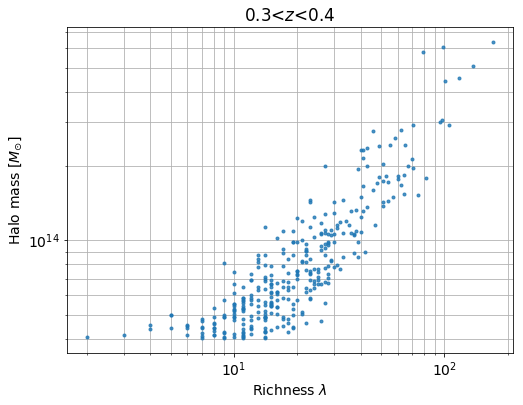

In [213]:
# Plot the mass-richness relation in DC2

plt.figure(figsize=(8,6))
plt.loglog(cluster_richness, 
            cluster_mass, 
            '.',
            alpha=0.8,
           )

plt.xlabel('Richness $\lambda$')
plt.ylabel('Halo mass [$M_{\odot}$]')
plt.title('%s<$z$<%s'%(z_cl_min, z_cl_max))
plt.grid(which='both')
plt.rcParams.update({'font.size': 20})
#plt.savefig('lambda_m_fig1.png')

## DES Y1 redMaPPer clusters (McClintock et al. 2018)

**Mass:** weak lensing

**Mass-richness relation:** the expectation value of the mass of a halo as a function of richness and redshift

$M(\lambda, z) = M_0 (\frac{\lambda}{\lambda_0})^F (\frac{1+z}{1+z_0})^G$
, where
$\lambda_0 = 40$, $z_0 = 0.35$ ($\sim$median)

The paper also gives comparison with previous studies (see below).

**Cosmology:** $\Omega_m=0.3$, $H_0=70\,\text{km}\, \text{s}^{-1}\, \text{Mpc}^{-1}$

**Magnitude cut:** $10\sigma$ in $z$, $5\sigma$ in $i$ and $r$, and $3\sigma$ in $g$.
Typical $10\sigma$ magnitude for galaxies: $g\sim23.7$, $r\sim23.5$, $i\sim22.9$, and $z\sim22.2$. Therefore the magnitude cut is $z\ge22.2$, $r\ge24.2$, $i\ge23.6$, $g\ge25.0$. (DECam Exposure Time Calculator; mostly sky background noise)

**Radius cut (max):** $R_{\lambda} = (\lambda/100)^{0.2} \, \text{h}^{−1} \text{Mpc}$

**Richness cut:** $\lambda$>20

**Redshift cut:** $0.2\le z\le0.65$

In [226]:
def M_DES_Y1(l, z):
    M0 = 3.081e14   #(+-0.075 +-0.133)e14
    # log10(M0) = 14.489 #+-0.011 +-0.019
    l0 = 40.
    z0 = 0.35
    F = 1.356   #+-0.051 +-0.008
    G = -0.30   #+-0.30 +-0.06
    return M0*(l/l0)**F*((1+z)/(1+z0))**G


def M_DES_Y1_lim(l, z, lim):
    # Assume l is an array but z is a numbe
    M0_min = (3.081-(0.075**2+0.133**2)**0.5)*1.0e14
    M0_max = (3.081+(0.075**2+0.133**2)**0.5)*1.0e14
    F_min = 1.356-(0.051**2+0.008**2)**0.5
    F_max = 1.356+(0.051**2+0.008**2)**0.5
    G_min = -0.30-(0.30**2+0.06**2)**0.5
    G_max = -0.30+(0.30**2+0.06**2)**0.5
    
    l0 = 40.
    z0 = 0.35
    
    arr = np.zeros_like(l)
    
    idx1 = l<=l0
    idx2 = l>l0

    if lim=='min':
        if z<=z0:
            arr[idx1] = M0_min*(l[idx1]/l0)**F_max*((1+z)/(1+z0))**G_max
            arr[idx2] = M0_min*(l[idx2]/l0)**F_min*((1+z)/(1+z0))**G_max
            #print(arr)
            return arr
        else:
            arr[idx1] = M0_min*(l[idx1]/l0)**F_max*((1+z)/(1+z0))**G_min
            arr[idx2] = M0_min*(l[idx2]/l0)**F_min*((1+z)/(1+z0))**G_min
            return arr

    elif lim=='max':
        if z<=z0:
            arr[idx1] = M0_max*(l[idx1]/l0)**F_min*((1+z)/(1+z0))**G_min
            arr[idx2] = M0_max*(l[idx2]/l0)**F_max*((1+z)/(1+z0))**G_min
            return arr
        else:
            arr[idx1] = M0_max*(l[idx1]/l0)**F_min*((1+z)/(1+z0))**G_max
            arr[idx2] = M0_max*(l[idx2]/l0)**F_max*((1+z)/(1+z0))**G_max
            return arr

    else: 
        print("Error: Limit string should be \'min\' or \'max\'.")
        return arr
    

def M_DES_SV(l, z):
    l_new = l/(1.08) #1.08+-0.16
    #print(l_new)
    M0 = 3.467e14   #
    # log10(M0) = 14.540 +- 0.067
    l0 = 40.
    z0 = 0.35
    F = 1.12    #+-0.21
    G = -0.30   #+-0.30 +-0.06 # assume the same as DES_Y1
    return M0*(l_new/l0)**F*((1+z)/(1+z0))**G


def M_SDSS(l, z):
    #Simet et al. (2017)
    l_new = l/(0.93) #0.93+-0.14
    #print(l_new)
    M0 = 3.020e14
    # log10(M0) = 14.48 +- 0.03
    l0 = 40.
    z0 = 0.35
    F = 1.30   #+- 0.09
    G = -0.30   #+-0.30 +-0.06  # assume the same as DES_Y1
    return M0*(l_new/l0)**F*((1+z)/(1+z0))**G


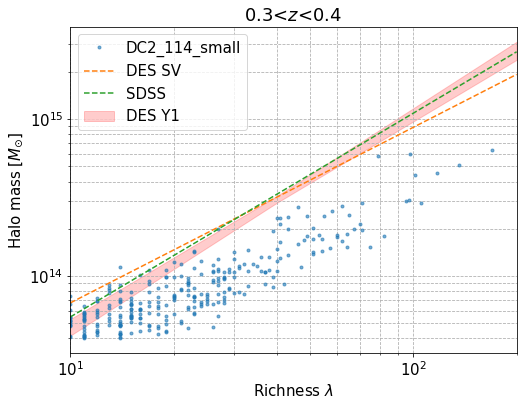

In [228]:
# Plot mass-richness relation in the paper

plt.figure(figsize=(8,6))
l = np.logspace(1, np.log10(200))

#plt.plot(l, M_DES_Y1(l, 0.35))

plt.fill_between(l, 
                 M_DES_Y1_lim(l, 0.35, 'min'),
                 M_DES_Y1_lim(l, 0.35, 'max'),
                 alpha=0.2,
                 label='DES Y1',
                 color='r',
                )

plt.plot(cluster_richness, 
         cluster_mass, 
         '.',
         alpha=0.6,
         label='DC2_114_small' #'cosmoDC2_v1.1.4_small', 
        )
#print(l)
plt.plot(l, 
         M_DES_SV(l, 0.35), 
         '--',
         alpha=1,
         label='DES SV' 
        )
#print(l)
plt.plot(l, 
         M_SDSS(l, 0.35), 
         '--',
         alpha=1,
         label='SDSS' 
        )
#print(l)
plt.xlim([10, 200])
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Richness $\lambda$')
plt.ylabel('Halo mass [$M_{\odot}$]')
plt.title('%s<$z$<%s'%(z_cl_min, z_cl_max))
plt.grid(which='both', ls='--')
plt.legend(loc='upper left')
plt.rcParams.update({'font.size': 15})
plt.savefig('lambda_m_fig2_lensed_mag.png')